# Ground removal
* PCA
* RANSAC
* Range image ground removal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import math
import copy
import os
from mayavi import mlab
from tools.ground_removal import *
from tools.ground_removal_kitti import *
import random
from time import time
import pandas as pd

In [2]:
pts, intens = get_frame_unsynchronized(10)
ground_mask = get_frame_ground_mask(10)
number_of_ground_points = ground_mask.sum()
no_ground_mask = get_frame_without_ground_mask(10)



NameError: name 'get_frame_unsynchronized' is not defined

In [3]:
# plot whole PCL
mlab.points3d(pts[:,0], pts[:,1], pts[:,2], intens, mode='point')
mlab.show()

In [4]:
# plot only ground
mlab.points3d(pts[ground_mask][:,0], pts[ground_mask][:,1], pts[ground_mask][:,2], intens[ground_mask], mode='point')
mlab.show()

In [61]:
# plot PCL with ground removed
mlab.points3d(pts[no_ground_mask][:,0], pts[no_ground_mask][:,1], pts[no_ground_mask][:,2], intens[no_ground_mask], mode='point')
mlab.show()

# PCA

In [6]:
# PCA
inliers_idx, outliers_idx = find_PCA_inliers_outliers(pts, 0.2, True)
inliers = pts[inliers_idx]
inliers_intens = intens[inliers_idx]
outliers_intens = intens[outliers_idx]
outliers = pts[outliers_idx]

pca_idx = np.zeros((pts.shape[0]))
pca_idx[inliers_idx] = 1

precision, recall, iou = calculate_metrics(pca_idx,ground_mask)

print(f"PCA: precision = {precision * 100 :.2f}%, recall = {recall * 100 :.2f}%,"\
      f" iou = {iou * 100 :.2f}%")
mlab.points3d(outliers[:, 0], outliers[:, 1], outliers[:, 2], outliers_intens, mode='point')
mlab.points3d(inliers[:, 0], inliers[:, 1], inliers[:, 2], color=(1,0,0), mode='point')
mlab.show()


PCA: precision = 91.85%, recall = 33.03%,iou = 32.09%


## RANSAC

In [7]:
# Ransac
inliers_idx, outliers_idx = ransac(pts, 10, 0.2, len(pts)/5)

inliers = pts[inliers_idx]
outliers = pts[outliers_idx]
outliers_intens = intens[outliers_idx]

ransac_idx = np.zeros((pts.shape[0]))
ransac_idx[inliers_idx] = 1

precision, recall, iou = calculate_metrics(ransac_idx,ground_mask)

In [59]:
print(f"RANSAC: precision = {precision * 100 :.2f}%, recall = {recall * 100 :.2f}%,"\
      f" iou = {iou * 100 :.2f}%")
mlab.points3d(outliers[:, 0], outliers[:, 1], outliers[:, 2], outliers_intens, mode='point')
#mlab.points3d(inliers[:, 0], inliers[:, 1], inliers[:, 2], color=(1,0,0), mode='point')

mlab.show()

RANSAC: precision = 87.75%, recall = 79.38%, iou = 71.47%


## Range image ground removal

In [76]:
from tools.semantic_kitti_api.auxiliary.laserscan import *
import yaml

CFG = yaml.safe_load(open("tools/semantic_kitti_api/config/semantic-kitti.yaml", 'r'))
path = "semantic_kitti_data"
color_dict = CFG["color_map"]
nclasses = len(color_dict)
scan = SemLaserScan(nclasses, color_dict, project=True)
data = np.fromfile('../../semantic_kitti_data/sequences/01/velodyne/000010.bin',dtype=np.float32)
data = data.reshape((-1,4))
xyz = data[:,0:3]
scan.set_points(xyz)


Range image

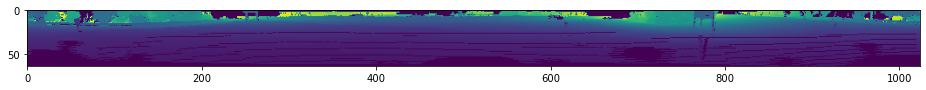

In [95]:
plt.figure(figsize=(16,1.5))
range_image = scan.proj_range
plt.imshow(range_image)
# plt.savefig('range_image_unrepaired')
plt.show()

Repaired range image

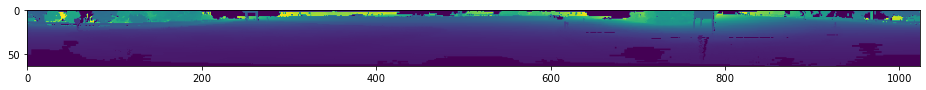

In [94]:
plt.figure(figsize=(16,1.5))
range_image_repaired = repair_depth(range_image)
plt.imshow(range_image_repaired)
# plt.savefig('range_image_repaired')
plt.show()

Angles

In [69]:
angles, angles_filtered = compute_angles(range_image_repaired)

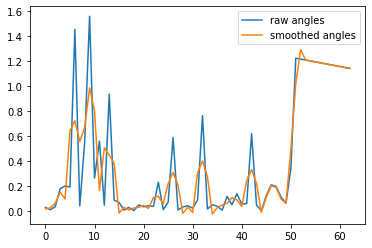

In [73]:
x = [x for x in range(63)]
plt.plot(x, angles[:,0], label='raw angles')
plt.plot(x, angles_filtered[:,0], label='smoothed angles')
plt.legend()
# plt.savefig('angles')
plt.show()

In [51]:
ground_labels = label_ground(angles_filtered, range_image_repaired)

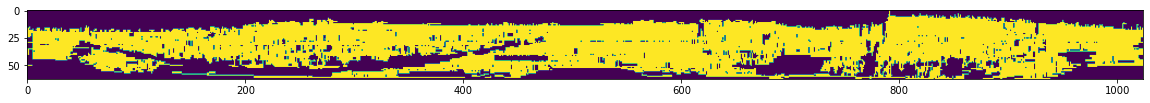

In [52]:
plt.figure(figsize=(20,20))
plt.imshow(ground_labels)

In [53]:
invalid = np.where(range_image[:-1] <= 0.001)
ground_labels = fill_invalid_pts_ground(ground_labels, invalid)

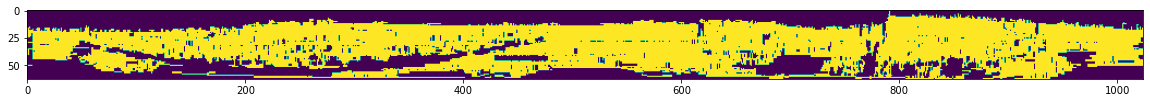

In [54]:
plt.figure(figsize=(20,20))
plt.imshow(ground_labels)

In [99]:
projected_predicted_ground = np.vstack((np.zeros(ground_labels.shape[1]), ground_labels))

mlab.points3d(scan.proj_xyz[:,:, 0], scan.proj_xyz[:,:, 1], scan.proj_xyz[:,:, 2], projected_predicted_ground , mode='point')
mlab.show()

In [158]:
color = range_image[~projected_predicted_ground.astype(bool)]
#color[color <= 0] = 0.0001
#color = color / color.max()
#color = -color
#color[color >= -0.5] = -0.8

In [159]:
pts_noground = scan.proj_xyz[~projected_predicted_ground.astype(bool)]
mlab.points3d(pts_noground[:, 0], pts_noground[:, 1], pts_noground[:, 2], color, mode='point')
mlab.show()

Projecting ground truth

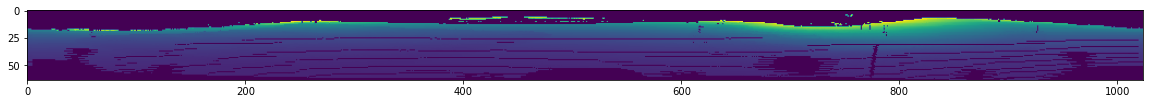

In [56]:
scan2 = SemLaserScan(nclasses, color_dict, project=True)
xyz2 = pts[ground_mask]
scan2.set_points(xyz2)
range_image = scan2.proj_range
plt.figure(figsize=(20,20))
plt.imshow(range_image)

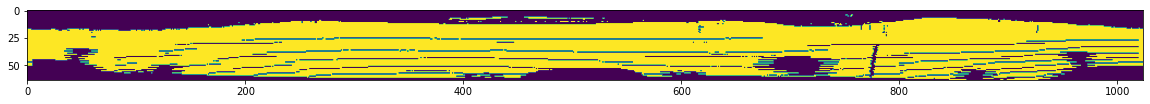

In [57]:
range_image[range_image < 0] = 0
range_image[range_image > 0] = 1
projected_true_ground = range_image
plt.figure(figsize=(20,20))
plt.imshow(projected_true_ground)

In [58]:
precision, recall, iou = calculate_metrics(projected_predicted_ground,projected_true_ground)
print(f"Range image GR: precision = {precision * 100 :.2f}%, recall = {recall * 100 :.2f}%,"
      f" iou = {iou * 100 :.2f}%")

Range image GR: precision = 87.75%, recall = 79.38%,iou = 71.47%


# evaluation of PCA RANSAC Range image

In [2]:
N = 10
# PCA ------------------------------------
precision = []; recall = []; iou = []; time_arr = []
for sequence in range(N):
      pts, intens = get_frame_unsynchronized(sequence)
      ground_mask = get_frame_ground_mask(sequence)
      number_of_ground_points = ground_mask.sum()
      no_ground_mask = get_frame_without_ground_mask(sequence)
      start = time()

      inliers_idx, outliers_idx = find_PCA_inliers_outliers(pts, 0.2, True)
      inliers = pts[inliers_idx]
      inliers_intens = intens[inliers_idx]
      outliers_intens = intens[outliers_idx]
      outliers = pts[outliers_idx]

      pca_idx = np.zeros((pts.shape[0]))
      pca_idx[inliers_idx] = 1

      end = time()
      time_arr.append(end-start)
      p, r, i = calculate_metrics(pca_idx,ground_mask)
      precision.append(p); recall.append(r); iou.append(i)
      print(f'PCA {sequence} / {N}')

precision_pca = round(sum(precision) / N, 4) * 100
recall_pca = round(sum(recall) / N, 4) * 100
iou_pca = round(sum(iou) / N, 4) * 100
average_time_pca = round(sum(time_arr) / N, 2)
'''
# RANSAC ------------------------------------
precision = []; recall = []; iou = []; time_arr = []
for sequence in range(N):
      pts, intens = get_frame_unsynchronized(sequence)
      ground_mask = get_frame_ground_mask(sequence)
      number_of_ground_points = ground_mask.sum()
      no_ground_mask = get_frame_without_ground_mask(sequence)
      start = time()

      inliers_idx, outliers_idx = ransac(pts, 10, 0.2, len(pts)/5)
      inliers = pts[inliers_idx]
      outliers = pts[outliers_idx]
      outliers_intens = intens[outliers_idx]
      ransac_idx = np.zeros((pts.shape[0]))
      ransac_idx[inliers_idx] = 1

      end = time()
      time_arr.append(end-start)
      p, r, i = calculate_metrics(ransac_idx,ground_mask)
      precision.append(p); recall.append(r); iou.append(i)
      print(f'RANSAC {sequence} / {N}')


precision_ransac = round(sum(precision) / N, 4) * 100
recall_ransac = round(sum(recall) / N, 4) * 100
iou_ransac = round(sum(iou) / N, 4) * 100
average_time_ransac = round(sum(time_arr) / N, 2)
'''
# Range image ------------------------------------
precision = []; recall = []; iou = []; time_arr = []

from tools.semantic_kitti_api.auxiliary.laserscan import *
import yaml
CFG = yaml.safe_load(open("tools/semantic_kitti_api/config/semantic-kitti.yaml", 'r'))
path = "semantic_kitti_data"
color_dict = CFG["color_map"]
nclasses = len(color_dict)
for sequence in range(N):

      file_name = "0" * int(6 - (len(str(sequence)))) + str(sequence)
      data = np.fromfile( "../../semantic_kitti_data/sequences/01/velodyne/" + file_name + ".bin", dtype=np.float32)
      data = data.reshape((-1,4))
      xyz = data[:,0:3]

      # projecting whole frame for prediction
      start = time()

      scan = SemLaserScan(nclasses, color_dict, project=True)
      scan.set_points(xyz)
      range_image = scan.proj_range
      range_image_repaired = repair_depth(range_image)
      angles, angles_filtered = compute_angles(range_image_repaired)
      ground_labels = label_ground(angles_filtered, range_image_repaired)
      invalid = np.where(range_image[:-1] <= 0.001)
      ground_labels = fill_invalid_pts_ground(ground_labels, invalid)
      projected_predicted_ground = np.vstack((np.zeros(ground_labels.shape[1]), ground_labels))

      end = time()
      time_arr.append(end-start)
      #projecting ground truth, time not measured
      ground_mask = get_frame_ground_mask(sequence)
      scan2 = SemLaserScan(nclasses, color_dict, project=True)
      xyz2 = xyz[ground_mask]
      scan2.set_points(xyz2)
      range_image2 = scan2.proj_range
      range_image2[range_image2 < 0] = 0
      range_image2[range_image2 > 0] = 1
      projected_true_ground = range_image2
      p, r, i = calculate_metrics(projected_predicted_ground,projected_true_ground)
      precision.append(p); recall.append(r); iou.append(i)
      print(f'range image {sequence} / {N}')

precision_range = round(sum(precision) / N, 4) * 100
recall_range = round(sum(recall) / N, 4) * 100
iou_range = round(sum(iou) / N, 4) * 100
average_time_range = round(sum(time_arr) / N, 2)

PCA 0 / 10
PCA 1 / 10
PCA 2 / 10
PCA 3 / 10
PCA 4 / 10
PCA 5 / 10
PCA 6 / 10
PCA 7 / 10
PCA 8 / 10
PCA 9 / 10
range image 0 / 10
range image 1 / 10
range image 2 / 10
range image 3 / 10
range image 4 / 10
range image 5 / 10
range image 6 / 10
range image 7 / 10
range image 8 / 10
range image 9 / 10


In [68]:
df = pd.DataFrame({'Method':['PCA', 'RANSAC', 'Range image'], 'Precision': [precision_pca, precision_ransac, precision_range], 'Recall': [recall_pca, recall_ransac, recall_range], 'IoU': [iou_pca, iou_ransac, iou_range], 'Time': [average_time_pca, average_time_ransac, average_time_range]})
df = df.set_index('Method')
display(df)
df.to_csv("ground_removal_evaluation")
df.to_latex('ground_removal_evaluation_tex')

,Precision,Recall,IoU,Time
Method,,,,
PCA,90.93,30.70,29.80,0.36
RANSAC,95.15,48.52,47.39,23.86
Range image,87.32,79.40,71.19,1.59


In [8]:
for i in range(20):
      start = time()
      scan1 = SemLaserScan(nclasses, color_dict, project=True)
      scan.set_points(xyz)
      range_image = scan.proj_range
      #range_image_repaired = repair_depth(range_image)
      angles, angles_filtered = compute_angles(range_image)
      print(time() - start)

0.43070101737976074
0.4620628356933594
0.40561413764953613
0.40437889099121094
0.4056389331817627
0.388063907623291
0.3853781223297119
0.3826150894165039
0.3756589889526367
0.375683069229126
0.37579798698425293
0.37960195541381836
0.38664984703063965
0.38553428649902344
0.4100608825683594
0.4213078022003174
0.4130208492279053
0.4098689556121826
0.39365291595458984
0.3827650547027588


Polynomial regression to fit line for ground removal?

In [3]:
PATH = "../../semantic_kitti_data/sequences/01/"
file_name = "0" * int(6 - (len(str(0)))) + str(0)
scan = np.fromfile(PATH + "velodyne/" + file_name + ".bin", dtype=np.float32)
scan = scan.reshape((-1, 4))
intensities = scan[:,3]
pts = scan[:,0:3]

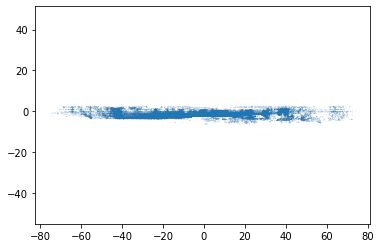

In [5]:
plt.axis('equal')
plt.scatter(pts[:,1],pts[:,2], s=0.001)

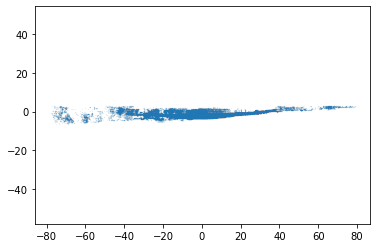

In [4]:
plt.axis('equal')
plt.scatter(pts[:,0],pts[:,2], s=0.001)

Linear regression

In [8]:
X = pts[:,0].reshape(-1,1)
Y = pts[:,1].reshape(-1,1)
Z = pts[:,2].reshape(-1,1)

from sklearn.linear_model import LinearRegression

LinearRegression()

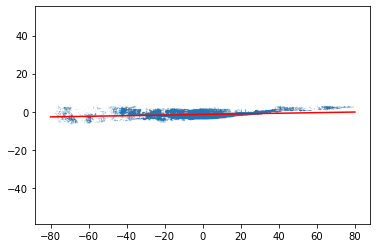

In [20]:
plt.axis('equal')
lin_reg=LinearRegression()
lin_reg.fit(X,Z)
plt.scatter(X,Z, s=0.001)
xs = np.arange(-80,80,0.1).reshape(-1,1)
plt.plot(xs, lin_reg.predict(xs),color="r")

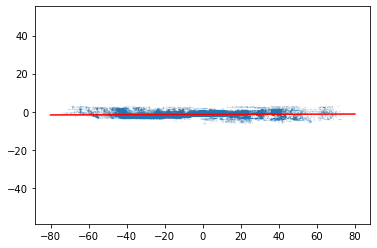

In [22]:
plt.axis('equal')
lin_reg=LinearRegression()
lin_reg.fit(Y,Z)
plt.scatter(Y,Z, s=0.001)
xs = np.arange(-80,80,0.1).reshape(-1,1)
plt.plot(xs, lin_reg.predict(xs),color="r")

Polynomial regression

In [23]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg=PolynomialFeatures(degree=3)

array([[ 1.9878117],
       [ 2.9062185],
       [ 2.9051187],
       ...,
       [-1.7468927],
       [-1.7519001],
       [-1.7709005]], dtype=float32)

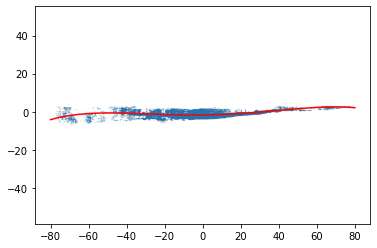

In [43]:
X_poly = poly_reg.fit_transform(X)
poly_reg.fit(X_poly,Z)
plt.axis('equal')
lin_reg=LinearRegression()
lin_reg.fit(X_poly,Z)
plt.scatter(X,Z, s=0.001)
xs = np.arange(-80,80,0.1).reshape(-1,1)
xs_poly = poly_reg.fit_transform(xs)
plt.plot(xs, lin_reg.predict(xs_poly),color="r")

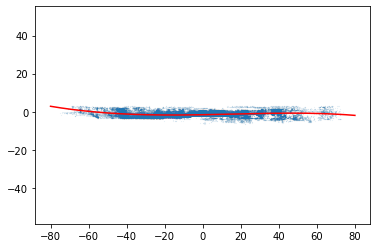

In [46]:
Y_poly = poly_reg.fit_transform(Y)
poly_reg.fit(Y_poly,Z)
plt.axis('equal')
lin_reg=LinearRegression()
lin_reg.fit(Y_poly,Z)
plt.scatter(Y,Z, s=0.001)
xs = np.arange(-80,80,0.1).reshape(-1,1)
xs_poly = poly_reg.fit_transform(xs)
plt.plot(xs, lin_reg.predict(xs_poly),color="r")

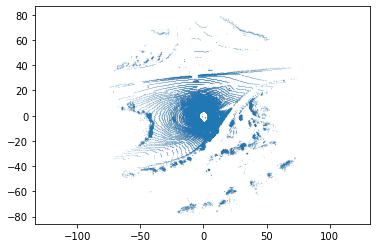

In [48]:
plt.axis('equal')
plt.scatter(Y,X, s=0.001)

## TODO weighted least squares, weighted by number of points around with similar Z coords

In [2]:
# using generated ground labels

In [3]:
gr = Ground_removal('18')
pts, _ = gr.get_frame(3)
mlab.points3d(pts[:,0], pts[:,1], pts[:,2], mode='point')
mlab.show()

In [12]:
pts, _ = gr.get_frame_without_ground(3)
pts.shape

(64922, 3)

In [6]:
mask = np.load("../../semantic_kitti_data/sequences/18/ground_label/000003.npy")

In [10]:
gr = Ground_removal('18')
pts, _ = gr.get_frame(3)
mlab.points3d(pts[:,0][mask], pts[:,1][mask], pts[:,2][mask], mode='point', color=(1,0,0))
mlab.points3d(pts[:,0][~mask], pts[:,1][~mask], pts[:,2][~mask], mode='point')
mlab.show()